# Linear Regression Unplugged: Neural Networks from Scratch Part 1

Linear regression is one of the most fundamental techniques in machine learning, often serving as a stepping stone to more complex models. While traditional linear regression is well understood, approaching it through the lens of neural networks opens up new dimensions of understanding, particularly in how we train models using gradient-based optimization methods.

In this short series, we will delve into the intricacies of modeling a linear regression problem using a neural network with a single neuron (though it might not qualify as a network). We will break down the forward and backward propagation processes, implementing everything from scratch in Python. Additionally, we will extend our implementation to leverage the power of CUDA for efficient computation on GPUs.

## Note

You may wonder why anyone would run linear regression solvers on a GPU when it can be solved in one step of matrix inversion. Well, that's a fair point. However, as the first sentence of this article suggests, it just serves perfectly as a stepping stone. This whole blog idea came to mind when I tried to understand the source code of [Andrej Karpathy's llm.c](https://github.com/karpathy/llm.c) and decided to refresh my C/C++ knowledge from college and learn CUDA. Then I thought: What is the simplest neural network I could implement in CUDA to start? A single neuron. What does a single neuron do? Linear Regression! And if I am spending time on this idea, why not write a post about it that might help others as well. So here we are.

**Narrator:** At that point, he didn't even have a clue how much effort the editing would take.

## Quick recap

Linear Regression is just a fancy phrase for fitting a hyperplane to a set of points so that the average distance between the points and the hyperplane is minimal. In an $n+1$ dimensional space, this hyperplane can formulated as follows:

\begin{equation}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n
\end{equation}

But let us stay in 2 dimensions. As one of my favourite professors used to say: "It also works in higher dimensions, but there I cannot draw that well".

\begin{equation}
y = \beta_0 + \beta_1 x
\end{equation}

This is something you may have already referred to as "the equation of a linear line". A line, that is the hyperplane of 2 dimensional spaces. Now, Let us generate a few sample data points with this formula (and some additional noise to make the problem even more interesting).

## Dataset generation

In [13]:
# YOU CAN SKIP THIS BLOCK

import numpy as np

RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

N = 10 # Number of examples
M = 1 # Number of features

# Generate features from the standard normal distribution
X = np.random.normal(size=(N,M))

# Generate coefficients from a uniform distrimution (beta_1)
coeff = np.random.uniform(low=-1.0, high=1.0, size=(M,1))

# Random intercept drawn from the range [-5, 5] uniformly (beta_0)
intercept = np.random.uniform() * 10 - 5

# Add some normally distributed noise with low standard deviation -> make the model's job harder
noise = np.random.normal(scale=2e-1, size=(N,1))

# Calculate the target using a linear combination of the features
y = X @ coeff + intercept + noise

## Plotting setup

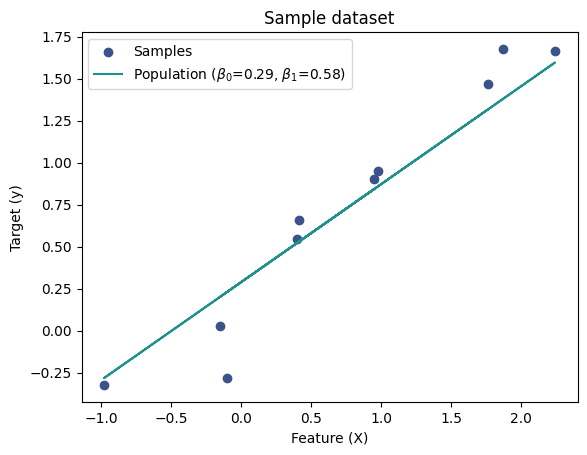

In [14]:
# YOU CAN SKIP THIS BLOCK

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import Colormap

# Colormap
cmap = plt.get_cmap("viridis", 5)

# Calculate the regression line
def linear_reg(x: np.ndarray, coeff: np.ndarray, intercept: float) -> np.ndarray:
    assert x.shape[-1] == coeff.shape[0]
    return x @ coeff + intercept

# Plot the data samples and the population distribution
def plot_dataset(cmap: Colormap, title: str = "Sample dataset") -> tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel("Feature (X)")
    ax.set_ylabel("Target (y)")
    ax.scatter(X, y[:,0], color=cmap(1), label="Samples")
    ax.plot(X, linear_reg(X, coeff, intercept), color=cmap(2), label=f"Population ($\\beta_0$={intercept:.2f}, $\\beta_1$={coeff[0,0]:.2f})")
    ax.legend()
    return fig, ax

fig, _ = plot_dataset(cmap) 
fig.savefig("../assets/plots/1_dataset.png")

As you can see, the generated data points are highly correlated. The true distribution (which we are generally looking for) is represented as a solid line. But the question is: how do we find the line based only on the sampled data points? One could argue that there is no way to do so, and that is true because of the random noise added to the data.

As already mentioned, linear regression aims to find the line that minimizes the average distance to the points. Isn't that what we are looking for? No, that line overfits the dataset, meaning it "learns" the random noise as well. But enough of the natural language; let us find this line in Python.

## Basic solution (Least Squares Method)

In [15]:
# Solution A (raw): Solving the linear equation
from scipy import linalg

# Add a column filled with ones, so one item of the matrix multiplication X @ [beta_0, beta_1].T
# can be calculated as 1*beta_0 + x_i*beta_1, that exactly gives us the formula of the linear line
A = np.hstack([np.ones_like(X), X])

# Use the Least Squares Method to solve the equation, that is find the beta parameters defining the line
(beta_0, beta_1), *_ = linalg.lstsq(A, y)

beta_0, beta_1


(array([0.20210562]), array([0.71490803]))

In [16]:
# Solution B (clean): Using the more convenient LinearRegression class
from sklearn.linear_model import LinearRegression

# Fit the model (calculate the parameters)
regressor = LinearRegression().fit(X, y)

beta_0, beta_1 = regressor.intercept_, regressor.coef_[0]

beta_0, beta_1

(array([0.20210562]), array([0.71490803]))

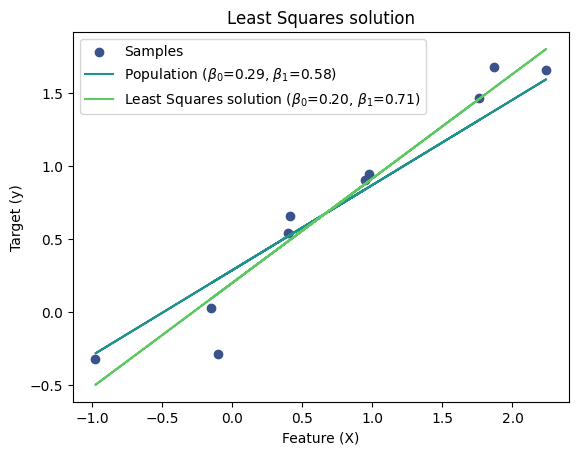

In [17]:
# YOU CAN SKIP THIS BLOCK

fig, ax = plot_dataset(cmap, title="Least Squares solution")
ax.plot(X, linear_reg(X, beta_1, beta_0[0]), color=cmap(3), label=f"Least Squares solution ($\\beta_0$={beta_0[0]:.2f}, $\\beta_1$={beta_1[0]:.2f})")
ax.legend()
fig.savefig("../assets/plots/1_lstsq.png")

Here it is. But I know you are really here to see some Neural Network magic, and so am I.

## Neural Network Solution

Have you ever seen an artificial neuron? The correct answer is yes. How do I know? I have just shown you one.

The formula I provided a few bytes earlier is exactly describes what a neuron is responsible for (and no, I do not consider the activation function part of the neuron as I am an engineer and not a neuroscientist; just imagine that it would be a Linear Unit there).

The only difference is that the coefficients ($\beta_1 \dots \beta_n$) are called weights, and the intercept ($\beta_0$) is called bias.

In Pytorch, one can easily create a perceptron (artificial neuron) by defining a Linear layer from the `nn` module with only one output feature (that is, one neuron):

In [18]:
import torch
from torch import nn

torch.manual_seed(RANDOM_SEED)

# The number of input features is also one, since we are in 2D
perceptron = nn.Linear(M, 1)

# Create Pytorch tensors from Numpy arrays
X_tensor = torch.from_numpy(X.astype(np.float32))
y_tensor = torch.from_numpy(y.astype(np.float32))

Now let's see what it can do.

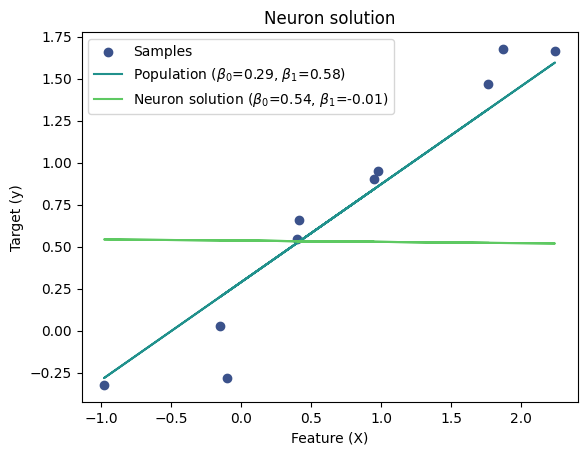

In [19]:
# YOU CAN SKIP THIS BLOCK

w, b = perceptron.weight.item(), perceptron.bias.item()
fig, ax = plot_dataset(cmap, title="Neuron solution")
ax.plot(X, perceptron(X_tensor).detach(), color=cmap(3), label=f"Neuron solution ($\\beta_0$={b:.2f}, $\\beta_1$={w:.2f})")
ax.legend()
fig.savefig("../assets/plots/1_neuron.png")

Ok, that's not it. The reason is very simple though: the parameters have been initialized randomly. The perceptron itself just the tool that calculates something (the output in this case). It's like a guitar: you buy one, but it doesn’t work as expected until you tune it. Once it is ready, you can give it a try, learn one or two chords, and then completely forget about its existence.

Back to the tuning, or rather, the "training". Training a neural network takes 4 steps:
 - Calculating the output using the current parameters (Forward propagation)
 - Measuring the loss, which is the error of the model
 - Determining the gradient of the loss with respect to the parameters of the model (Backward propagation)
 - Updating the parameters using the gradients

 Let us look into each one briefly (except the forward pass, we are already pros at that one).

### Loss calculation

Since we are dealing with a regression problem, our target variable is continuous. As mentioned, the model attempts to minimize the average distance between the line (model's prediction) and the data points (target). Therefore, the error of the model is measured as this average distance, known as Mean Absolute Error (MAE). However, applying a monotonic function to the error yields the same optimization results. One popular variation is the Mean Squared Error (MSE), which amplifies the error and accelerates convergence. We are going to use this as our loss function today:

\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{equation}

### Backward propagation

It is just simple calculus. Our purpose is to find the model (specified by its parameters) that produces the minimal loss. So, just as we were taught in high school, we calculate the derivative of the loss function with respect to each parameter and find its root, which gives us what we are looking for. Well, it is a bit more difficult because we don't know the values of the loss at each point. The only thing we know is the measurements made at the given data points (previous step). So, we need something else from math—some method that is more advanced and provides a framework to find out the direction we should take a step in to decrease the current loss. By definition, gradients point to the steepest ascent (the direction in which the function can be increased the most). So, let's go in the opposite direction.

Backward propagation is basically the process of calculating these gradients. It is needed because the parameters only affect the loss indirectly (through a chain of functions). This method uses the Chain Rule of Calculus to factorize the formula so that one can calculate local gradients one-by-one and multiply them together to get the final (global) gradients. In the next episode, we are going to take a deep dive into the intricacies of this method and implement it from scratch, but I think this is enough for now.

### Updating the parameters

With the gradients in hand, we know the direction we should move the parameters, but how far should we move? Several algorithms address this question, and today we will use the simplest one. This method is called Gradient Descent, uses the hyperparameter λ called Learning Rate to scale the gradients, and updates the parameter 𝑝 by:

\begin{equation}
p_1 \leftarrow p_0 - \lambda \frac{\partial \text{MSE}}{\partial p}
\end{equation}

In [20]:
# Arrays to save the results and parameters in each iteration
results = []
params = []
# Number of iterations (in our case it matches the number of parameter updates)
EPOCHS = 20
# An optimizer that takes care of Gradient Descent
# it updates the model's parameters (weight and bias) with a Learning Rate of 0.1
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.1)

# Training loop
for i in range(EPOCHS):
    # Zero all the parameter gradients at the start of each epoch
    # otherwise they would be accumulating over the epochs
    optimizer.zero_grad()

    # Forward pass
    y_hat = perceptron(X_tensor)

    # Saving subresults for plotting
    results.append(y_hat.detach().numpy())
    params.append((perceptron.weight.item(), perceptron.bias.item()))

    # Loss calculation
    loss = nn.functional.mse_loss(y_hat, y_tensor)

    # Backward pass
    loss.backward()
    
    # Parameter update
    optimizer.step()

In [21]:
# YOU CAN SKIP THIS BLOCK

# Animating results
from matplotlib import animation

w, b = params[0]
fig, ax = plot_dataset(cmap, title="Neuron training")
nn_plot = ax.plot(X, results[1], color=cmap(3), label=f"Neuron solution ($\\beta_0$={b:.2f}, $\\beta_1$={w:.2f})")[0]
epoch = ax.text(0.01, 0.01, "Epoch 1", fontsize=12, transform=plt.gcf().transFigure)

ax.legend()

def update(frame):
    w, b = params[frame]
    nn_plot.set_label(f"Neuron solution ($\\beta_0$={b:.2f}, $\\beta_1$={w:.2f})")
    nn_plot.set_ydata(results[frame])
    epoch.set_text(f"Epoch {frame}")
    ax.legend()
    return nn_plot

ani = animation.FuncAnimation(fig=fig, func=update, frames=EPOCHS, interval=10)
ani.save("../assets/plots/1_neuron_learning.gif", writer="pillow", fps=5)
plt.close(fig)


![Neaural Network during training](../assets/plots/1_neuron_learning.gif)

As we can see, our little perceptron gets closer and closer to the Least Squares solution with each parameter update. This is how we can model linear regression with a single neuron of a neural network. Next time, we will delve deeper into Backward Propagation and parameter updates, implementing it from scratch (without PyTorch's Autograd and optimizers). After that, we'll dive into the CUDA implementation—the real reason I’m spending my evenings studying.